In [7]:
%matplotlib inline
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from lending_club.loan_prediction.loan_predictor import LoanPredictor

In [2]:
lp = LoanPredictor()

loaded /Users/jonathan/Documents/Repos/lending_club/data/LoanStats3d.csv
handling missing data...
transforming features...


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


## Goal ##

The goal was to train a model that can predict which loans will be fully paid versus charged off at the time they are issued. These represent a loss versus a return for an investor. The loans in the data have other states such current and late, which have unkown risks of charging off. The dataset is not longitudinal but merely a snapshot in time. 

## Missing Features ##

Notably missing from the Lending Club datasets are FICO or other credit related scores. These features are indicated in the data dictionary but appear to have been stripped. Additional features present in the data dictionary are also not present in the data. 

## Dataset ##

The 2015 sample of Loan stats was used for analysis and modeling. This represents 421097 rows with 111 columns. 

## Feature Engineering ##


### Removing Future Features ###
Since the goal is to predict the risk of charge off at the time that a loan is applied for and issued, we dropped all features that pertain to the ongoing financial history of the customer and features related to repayment and payments made.  We retained features that would have been known at the time of underwriting. 


### Missing Data ###

- 2 loans were missing loan amounts and were dropped. 
- The revolving credit utilization (revol_util) was convered from a string percentage to a a float.  The missing revolving utilizations were imputed with the median from the entire dataset. 
- Missing number of reolving accounts was assumed to represent no accounts and filled with 0. 
- Similarly, months since oldest bank installment was filled with 0 when missing. 


### Feature Transformation ###

- **earliest_cr_line**:  The earliest credit line was transformed from a date to months since
- **int_rate**: The interest rate was transformed froma  a string percentage to a float
- **issue_d**:  To see if the month in which a loan is issue impacts the charge off risk, the month was extracted  from the issue  data


### Feature Removal ###

- **descriiption**: missing on more than 80% of the loans, no text analysis performed
- **title**:  free-form user supplied, mostly overlaps with purpose but it less structured
- **zip-code**: high-cardinality, would be useful for joining with external economic data but not here
- **emp-title**:  high-cardinality, effort would be required to normalize titles
- **joint applications**:  represent a very small minority of loans, too few to reasonably learn from
- **grade**: sub-grade was chosen for more granularity. Grade and sub-grade are redundant. 


### Feature Coding ###

- **ordinal features**: employment length and subgrade were treated as ordinal features and coded as ranked integers
- **categorical features**: "verification_status","issue_d","term","home_ownership","purpose","addr_state" were dummy encoded

### Data Labeling###

As stated the goal is to predict between two classes: Fully Paid and Charged Off. All other loan statuses represent intermediate states with unknown associated risks for eventually charging off.  The dataset is effectively censored with the majority of loans in progress and about 25% of the loans being fully mature.  Fully Paid was given the label 1 and Charged Off was given the label 0. All other statuses were dropped from the data used for modeling. 



## Imbalanced Classes and Undersampling ##

More than 75% of the loans in the dataset have a status Fully Paid with less then 25% have the status Charged Off. When presented with such inbalanced classes, most classifiers tend to overfit to the majority class and ignore the minority class. To ameliorate this, undersampling and oversampling techniques can be employed during training. While numerious statistical approaches to sampling exist, none that I find are compatabile with the sci-kit learn GridSearchCV model tuning pclages.  I chose to use basic random undersampling of the majority class.  Importantly, undersampling was only used during training. The model was evaluated on the original imbalanced dataset. 


## Model Selection##

A gradient boosting classifer provide by by the xgboost package was chosen.  A boosted tree method was employed because they produce interpretable models and tend to perform well with a sizeable number of features. Additionaly, the boosting often affords better perfornmance than non-boosted binary classifiers such as logistic regression.   The xgboost implementation is fast, which makes hyperparameter tuning feasible on a a larger dataset and regularized, which limits the potential for overfitting. 

Hyperparameters were tuned using GridSearchCV from scikit-lean. The model was scored using ROC-AUC. This was chosen to detect poor performance on the minority class. 

Due to the size of the data, running the search took many hours on a 4 core machine.  The best parameters from the search were used for final model evaluation.



## Model Evaluation ##

In [3]:
cm, metrics = lp.train_test()
metrics

{'precision': 0.86638243518486557, 'recall': 0.63005083788363769}

The best model when tested on non-undersampled data has a precision of 0.86 and a recall of 0.64. For the purposes of an investor choosing which loans to invest it this is is a great start. Precision is more important because we don't want to choose a loan that is going to be Charged Off.  The recall would ideally be better, it means that we'd be loosing investment opportunities because good loans would be labeled as bad loans. 

## Model Interpretation ##

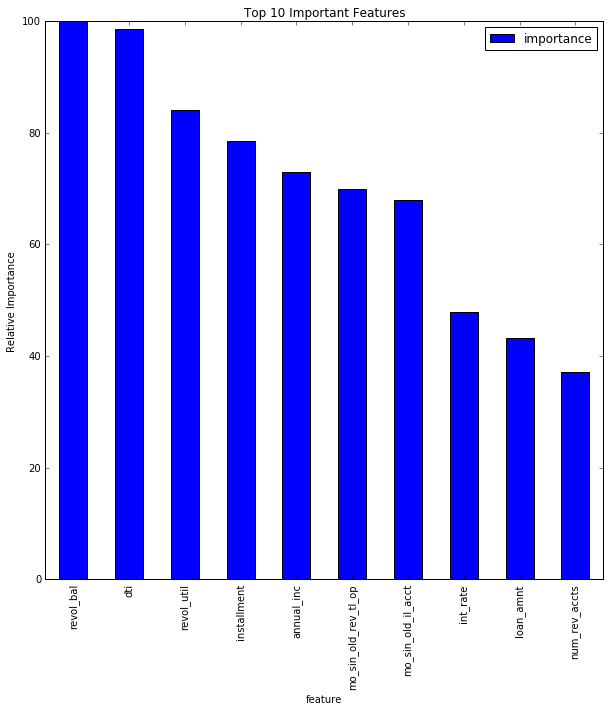

In [14]:
feature_importances = lp.feature_importances()
ax = feature_importances.iloc[:10].plot(figsize=(10,10),kind="bar")
ax.set_title("Top 10 Important Features")
_ = ax.set_ylabel("Relative Importance")



Features relatedt to the amount of debt and the debt to income ratio held appear to be most important to predicting the outcome of a loan.  Interestingly, the loand installment payment is more important than the overall loan amount. This likely impacts monthly cash flow more and could place someone at greater risk of defaulting and eventually being Charged Off.  It is also interesting that the lenght of time one has had a revolving account is more impoortant than the interest rate on the loan in predicting the outcome. 

## Next Steps ##

- investigate using macroeconomic features (e.g. median income, umeploymnent rates) from governmental sources. Only the first three digits of the zipcode are given so a median/mean approach would have to be taken

- expand the grid search for model hyperparameter tuning. Due to time constraints, I only ran a limited set of parameters and values. 

- consider incporating text based fetures from the description or job title